# 15分足で、1足以内の値動きの分析

## 目的
- 15分足でトレードするときに、どの程度の期間保有していれば十分な値動きが見込めるかを推定すること。
- 例えばもし1足の値動きが十分大きければ、1足以内に手仕舞う戦略でも機能する可能性がある。
- コストは1トレード（往復）あたり`$4`と想定する。
    - 手数料（往復）　　　：`$1`
    - スリッページ（往復）：`$3`
- したがって、値動きが`$4`より大きいと期待される期間以上保有していれば、それが勝ちトレードなら利益が出ることになる。

**【注意】　このデータの数値はドルではなくティック。1ティック=$5という換算。最小単位は0.25ティックなので1ティック以上の値動きがあればコストを差し引いても利益を出せる。**

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as st
import statsmodels.stats.anova as anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale
from joblib import Parallel, delayed
from functools import reduce

import finalib as fl
import finalib.mine as mi
import ta

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# データ読み込み

In [2]:
# 生データ
sp_dir = 'data/e-mini-sp500-200530'
df_sp_raw = pd.read_csv(f'{sp_dir}/e-mini-sp500-15min.csv')

In [3]:
# 月次データ（1年ごとの価格変化を見るため）
df_spm_raw = pd.read_csv(f'{sp_dir}/e-mini-sp500-monthly.csv')

In [4]:
df_sp_raw

,Date,Time,Open,High,Low,Close,Up,Down
0,09/11/1997,04:45,1082.25,1082.25,1079.75,1079.75,5,0
1,09/11/1997,06:00,1079.25,1079.25,1079.25,1079.25,1,0
2,09/11/1997,08:15,1078.75,1078.75,1078.00,1078.00,5,0
3,09/11/1997,08:30,1078.00,1078.25,1077.00,1077.00,8,0
4,09/11/1997,08:45,1076.50,1077.00,1074.75,1074.75,25,0
...,...,...,...,...,...,...,...,...
494258,05/29/2020,15:45,3033.25,3038.50,3030.00,3036.00,30761,29038
494259,05/29/2020,16:00,3036.00,3046.25,3030.00,3038.50,104765,116594
494260,05/29/2020,16:15,3038.50,3055.00,3036.75,3054.25,56756,53971
494261,05/29/2020,16:45,3053.00,3058.25,3051.00,3056.50,4965,5882


# 分析用データ作成

In [17]:
df = df_sp_raw.copy()

# DateTime列を追加
df['DT'] = (df['Date'] + '-' + df['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))

# 1997と2020はデータが不十分のため除く
df = df[(df['DT']>dt.datetime(1998,1,1)) & (df['DT']<dt.datetime(2020,1,1))]

# 値動き（終値 - 始値）列を追加
df['CODiff'] = df['Close'] - df['Open']

# 年の列を追加
df['year'] = df['DT'].map(lambda d: d.year)

# 年の順序付け
year_type = CategoricalDtype(categories=range(df['year'].min(), df['year'].max()+1), ordered=True)
df['year'] = df['year'].astype(year_type)

In [18]:
# 上昇、不変、下落
df['isUp'] = df['CODiff'] > 0
df['isFlat'] = df['CODiff'] == 0
df['isDown'] = df['CODiff'] < 0

### 年次データの作成（月次データを1年ごとに平均する）

In [28]:
dfm = df_spm_raw.copy()
dfm['DT'] = (dfm['Date'] + '-' + dfm['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))

# 15分足データに合わせて1997と2020を除く
dfm = dfm[(dfm['DT']>dt.datetime(1998,1,1)) & (dfm['DT']<dt.datetime(2020,1,1))]

dfm['year'] = dfm['DT'].map(lambda x: x.year)

dfm_by_year = dfm.groupby('year').mean()

# 1足以内の上昇幅（高値ー始値）の分布
仕掛けるのは基本的に始値だから、1足以内で見込める最大利益幅は（高値ー安値）ではなく（高値ー始値）となる。

In [20]:
df['HODiff'] = df['High'] - df['Open']

count    480458.000000
mean          1.002531
std           1.405274
min           0.000000
25%           0.250000
50%           0.500000
75%           1.250000
max          61.750000
Name: HODiff, dtype: float64

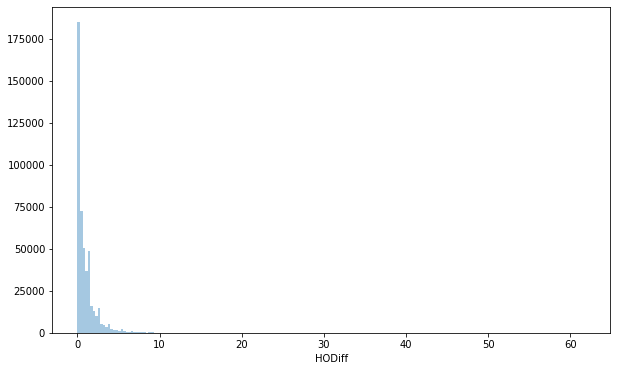

In [21]:
# 1足以内の上昇幅
fig = plt.figure(figsize=(10, 6))
sns.distplot(df['HODiff'], bins=200, kde=False)
df['HODiff'].describe()

In [22]:
# 1足以内で上昇幅が0より大きい割合（上昇した足の割合ではなく、高値が始値より高い割合）
df_up = df[df['HODiff'] > 0]
print(f"P(HODiff > 0) ={df_up.shape[0] / df.shape[0] * 100}%")

# 2枚でトレードする場合はコストを半分（$2）と考えてよいので、0.5ティック以上の動きがあれば利益を出せる。
# 1足以内で上昇幅が1ティック以上の割合（この足を捉えられれば1足以内でも利益を出せる可能性がある）
df_up0_5 = df[df['HODiff'] >= 0.5]
print(f"P(HODiff >= 0.5) ={df_up0_5.shape[0] / df.shape[0] * 100}%")

# 1足以内で上昇幅が1ティック以上の割合（この足を捉えられれば1足以内でも利益を出せる可能性がある）
df_up1 = df[df['HODiff'] >= 1]
print(f"P(HODiff >= 1) ={df_up1.shape[0] / df.shape[0] * 100}%")

P(HODiff > 0) =83.39022349508177%
P(HODiff >= 0.5) =61.55251863846579%
P(HODiff >= 1) =36.08723343143417%


In [83]:
# 1足以内の上昇幅平均値と中央値の1年毎の推移
df_by_year_mean = df.groupby('year')['HODiff'].mean()
df_by_year_median = df.groupby('year')['HODiff'].median()
df_up_by_year_mean = df_up.groupby('year')['HODiff'].mean()
df_up0_5_by_year_mean = df_up0_5.groupby('year')['HODiff'].mean()
df_up1_by_year_mean = df_up1.groupby('year')['HODiff'].mean()

In [69]:
# 1年毎で1足以内の最大値幅
df_by_year = df.groupby('year')['HODiff'].count()
df_up_by_year = df_up.groupby('year')['HODiff'].count()
df_up1_by_year = df_up1.groupby('year')['HODiff'].count()
df_up0_5_by_year = df_up0_5.groupby('year')['HODiff'].count()
df_up_by_year

year
1998    10847
1999    11482
2000    11851
2001    14736
2002    16822
2003    17287
2004    17097
2005    16871
2006    17286
2007    18928
2008    20746
2009    20646
2010    20544
2011    20759
2012    20358
2013    19761
2014    19964
2015    20921
2016    20934
2017    20021
2018    21332
2019    21462
Name: HODiff, dtype: int64

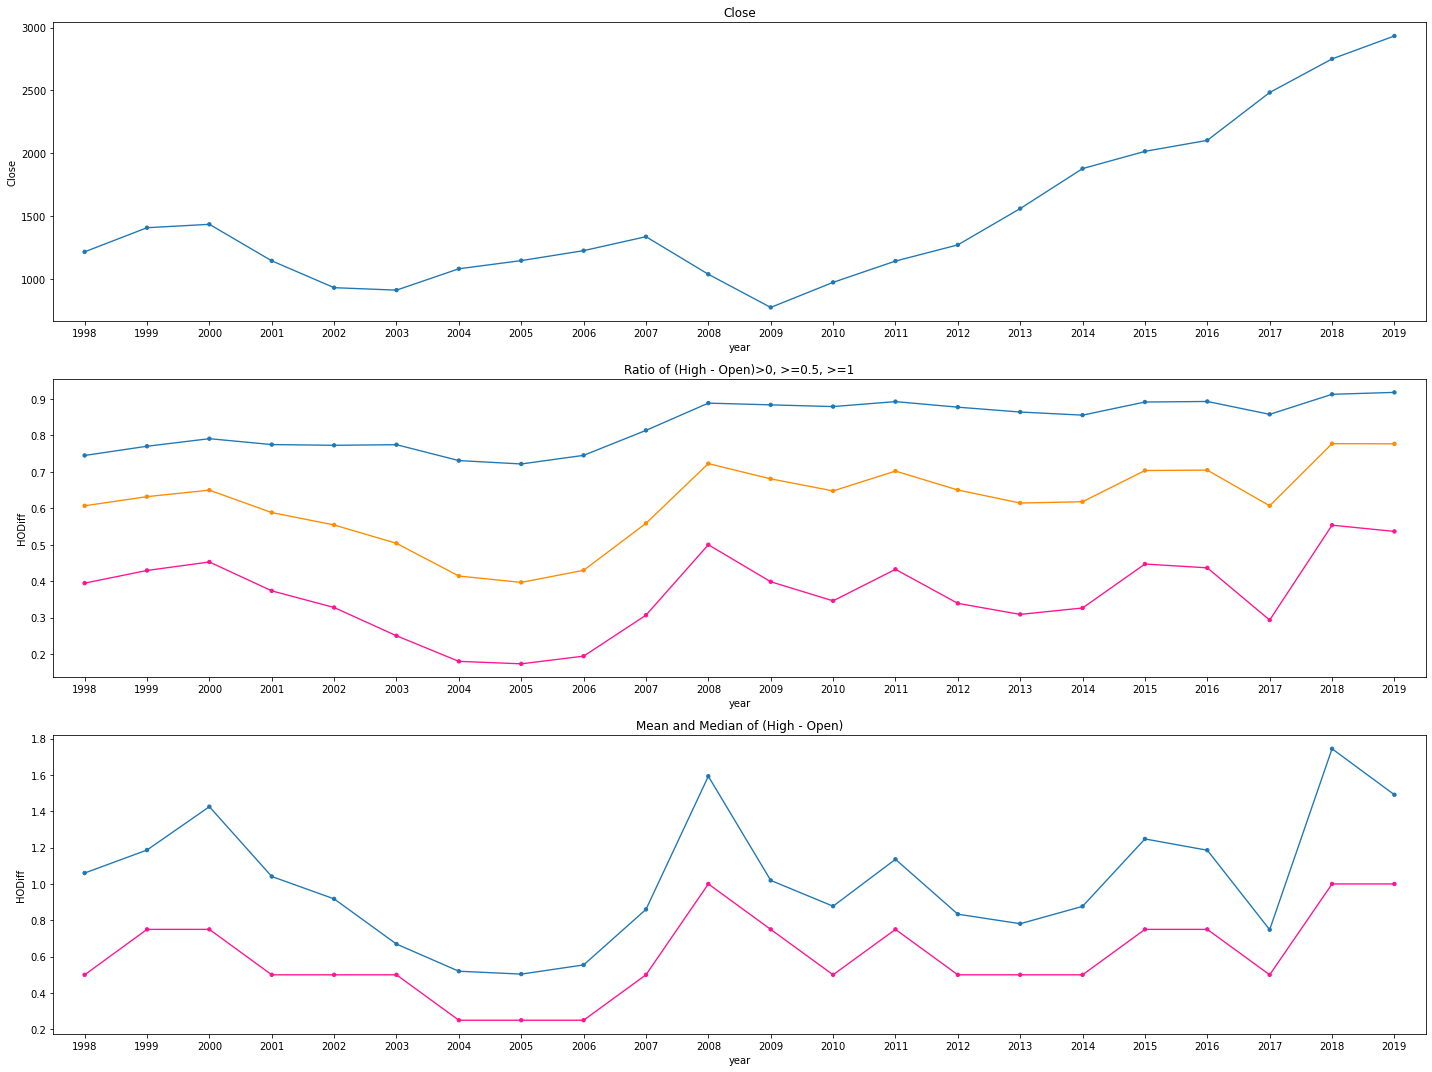

In [87]:
# 1年毎で1足以内の最大値幅の推移
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
sns.axes_style("whitegrid")
sns.pointplot(dfm_by_year.index, dfm_by_year['Close'], scale=0.5, ax=ax[0], label='Close')
sns.pointplot(df_up_by_year.index, df_up_by_year/df_by_year, scale=0.5, ax=ax[1], label='>0')
sns.pointplot(df_up1_by_year.index, df_up1_by_year/df_by_year, scale=0.5, ax=ax[1], label='>=1', color='deeppink')
sns.pointplot(df_up0_5_by_year.index, df_up0_5_by_year/df_by_year, scale=0.5, ax=ax[1], label='>=0.5', color='darkorange')
sns.pointplot(df_by_year_mean.index, df_by_year_mean, scale=0.5, ax=ax[2], label='mean')
sns.pointplot(df_by_year_median.index, df_by_year_median, scale=0.5, ax=ax[2], label='median', color='deeppink')

titles = ['Close', 'Ratio of (High - Open)>0, >=0.5, >=1', 'Mean and Median of (High - Open)']
for i,t in enumerate(titles):
    ax[i].set_title(t)

plt.tight_layout()

No handles with labels found to put in legend.


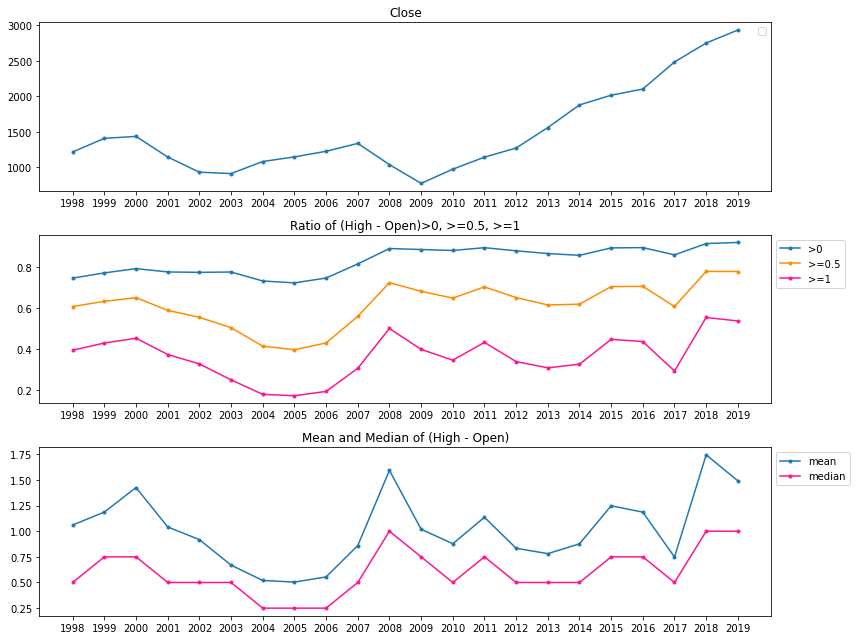

In [111]:
# 1年毎で1足以内の最大値幅の推移
fig, ax = plt.subplots(3, 1, figsize=(12, 9))
ax[0].plot(dfm_by_year.index, dfm_by_year['Close'], marker='.')
ax[1].plot(df_up_by_year.index, df_up_by_year/df_by_year, marker='.', label='>0')
ax[1].plot(df_up0_5_by_year.index, df_up0_5_by_year/df_by_year, marker='.', label='>=0.5', color='darkorange')
ax[1].plot(df_up1_by_year.index, df_up1_by_year/df_by_year, marker='.', label='>=1', color='deeppink')
ax[2].plot(df_by_year_mean.index, df_by_year_mean, marker='.', label='mean')
ax[2].plot(df_by_year_median.index, df_by_year_median, marker='.', label='median', color='deeppink')

titles = ['Close', 'Ratio of (High - Open)>0, >=0.5, >=1', 'Mean and Median of (High - Open)']
for i,t in enumerate(titles):
    ax[i].set_title(t)
    ax[i].set_xticks(dfm_by_year.index)
    ax[i].legend(bbox_to_anchor=(1,1))

plt.tight_layout()

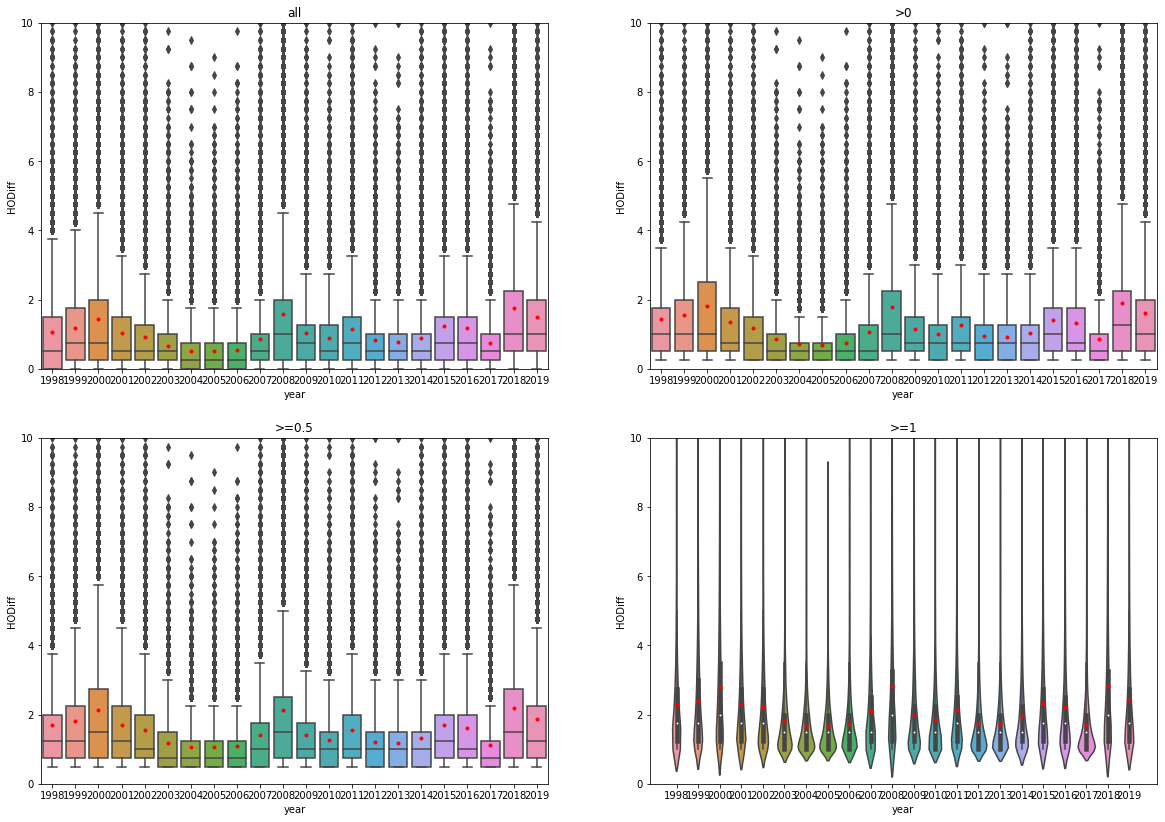

In [101]:
# 1足以内の上昇幅（高値ー始値）の年毎の分布
# 全データでの分布
# (>0)データのみの分布（上昇を捉えられた場合）
# (>=0.5)データの分布
# (>=1)データの分布
from itertools import product

fig, ax = plt.subplots(2, 2, figsize=(20, 14))
sns.boxplot('year', 'HODiff', data=df, ax=ax[0,0])
ax[0,0].plot(range(df_by_year_mean.size), df_by_year_mean, linestyle='', marker='.', color='red')
sns.boxplot('year', 'HODiff', data=df_up, ax=ax[0,1])
ax[0,1].plot(range(df_up_by_year_mean.size), df_up_by_year_mean, linestyle='', marker='.', color='red')
sns.boxplot('year', 'HODiff', data=df_up0_5, ax=ax[1,0])
ax[1,0].plot(range(df_up0_5_by_year_mean.size), df_up0_5_by_year_mean, linestyle='', marker='.', color='red')
sns.violinplot('year', 'HODiff', data=df_up1, ax=ax[1,1])
ax[1,1].plot(range(df_up1_by_year_mean.size), df_up1_by_year_mean, linestyle='', marker='.', color='red')

titles = ['all', '>0', '>=0.5', '>=1']
for (i,j),title in zip(product(range(2), range(2)), titles):
    ax[i,j].set_ylim(0, 10)
    ax[i,j].set_title(title)

([<matplotlib.axis.YTick at 0x7fd3fc874c10>,
 <a list of 11 Text major ticklabel objects>)

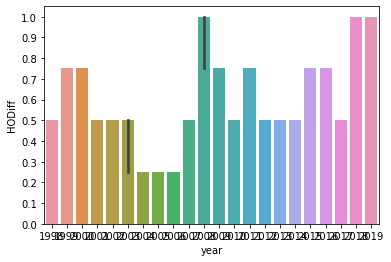

In [40]:
sns.barplot('year', 'HODiff', data=df, estimator=np.median)
plt.yticks(np.arange(0, 1.1, 0.1))

In [117]:
df.corr().style.background_gradient(axis=None)

,Open,High,Low,Close,Up,Down,CODiff,isUp,isFlat,isDown,HODiff
Open,1.000000,0.999997,0.999997,0.999996,0.015506,0.015364,0.001568,0.028651,-0.065564,0.019631,0.090429
High,0.999997,1.000000,0.999994,0.999998,0.016535,0.016179,0.002973,0.029629,-0.065970,0.018949,0.092683
Low,0.999997,0.999994,1.000000,0.999998,0.014587,0.014239,0.003054,0.029359,-0.065154,0.018617,0.090357
Close,0.999996,0.999998,0.999998,1.000000,0.015647,0.015124,0.004311,0.030257,-0.065566,0.018021,0.092124
Up,0.015506,0.016535,0.014587,0.015647,1.000000,0.967985,0.051279,0.093191,-0.144594,0.013177,0.453939
Down,0.015364,0.016179,0.014239,0.015124,0.967985,1.000000,-0.087531,0.004939,-0.142572,0.100266,0.359895
CODiff,0.001568,0.002973,0.003054,0.004311,0.051279,-0.087531,1.000000,0.585502,-0.000999,-0.586946,0.618198
isUp,0.028651,0.029629,0.029359,0.030257,0.093191,0.004939,0.585502,1.000000,-0.372684,-0.728672,0.433101
isFlat,-0.065564,-0.065970,-0.065154,-0.065566,-0.144594,-0.142572,-0.000999,-0.372684,1.000000,-0.363959,-0.184856
isDown,0.019631,0.018949,0.018617,0.018021,0.013177,0.100266,-0.586946,-0.728672,-0.363959,1.000000,-0.298285
